[link text](https://)

This demo requires the manual download of the cityscapes-datset from https://www.cityscapes-dataset.com/
You will need to download gtFine_train_val_test and LeftImg8bit_train_val_test Zip files.
For this demo the files are uploaded to my google drive, but this makes the code very slow. It is recommended to train locally or upload them in colab (although they only stay for one runtime session!) via


```
from google.colab import files
uploaded = files.upload()
```




In [ ]:
# STEP 1: import necessary modules 
import os
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
#%pip install keras==2.4.3
from keras.utils import generic_utils
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import tensorflow as tf
%pip install -U segmentation-models
import segmentation_models as sm



Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)
Segmentation Models: using `keras` framework.


In [ ]:
print(tf.__version__)
tf.test.gpu_device_name()

2.4.1


'/device:GPU:0'

In [ ]:
# to check whether we actually have access to a gpu
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.2 GB  | Proc size: 938.8 MB
GPU RAM Free: 14887MB | Used: 222MB | Util   1% | Total 15109MB


In [ ]:
# in case the GPU is already occupied before you start, uncomment line below
# !kill -9 -1

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# STEP 2: define constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
# SET image height and width. Height 1024 and width 2048 is original resolution
IMAGE_HEIGHT = 224  # for demonstration purposes
IMAGE_WIDTH = 448
# 100k pixels per channel
# original size: 2.1 miljoen pixels !!
IMAGE_CHANNELS = 3 #RGB
BATCH_SIZE = 8  # maximum batch size mogelijk bij deze resolutie op colab gpu voor deze dataset
N_CLASSES = 34
LABEL_NAMES = np.asarray([
    'unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground',
    'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge',
    'tunnel', 'pole', 'pole group', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
    'person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle'])

# define path to image and masks (= rootdir)
PATH = r'/content/drive/MyDrive/'

# seeding for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# STEP 3: load data.
# load list of paths to images and masks
# sorted to make sure images and masks are paired correctly
train_image_path = sorted(glob(os.path.join(PATH, r'leftImg8bit/train/*.png')))
train_mask_path = sorted(glob(os.path.join(PATH, r'gtFine/train/*/*_labelIds.png')))
test_image_path = sorted(glob(os.path.join(PATH, r'leftImg8bit/val/*.png')))
test_mask_path = sorted(glob(os.path.join(PATH, r'gtFine/val/*/*_labelIds.png')))
print(train_image_path[0])
# Because we have not much data, we throw all the data together and split 80:10:10
image_path = train_image_path + test_image_path
mask_path = train_mask_path + test_mask_path
# Split in 80% train, 20% validation
train_images, valid_images = train_test_split(image_path, test_size=0.2, random_state=42)
# split the validation half validation and half test
valid_images, test_images = train_test_split(valid_images, test_size=0.5, random_state=42)
train_masks, valid_masks = train_test_split(mask_path, test_size=0.2, random_state=42)
valid_masks, test_masks = train_test_split(valid_masks, test_size=0.5, random_state=42)

num_train_images = len(train_images)
num_valid_images = len(valid_images)
num_test_images = len(test_images)
print(f"Number of training images: {int(num_train_images)}")
print(f"Number of validation images: {int(num_valid_images)}")
print(f"Number of test images: {int(num_test_images)}")

/content/drive/MyDrive/leftImg8bit/train/aachen_000000_000019_leftImg8bit.png
Number of training images: 2780
Number of validation images: 347
Number of test images: 348


In [ ]:
# STEP 4: Create functions for data handling
def read_image(path):  # Load original image
    image = tf.io.read_file(path)  # read file path
    image = tf.image.decode_png(image, channels=3)  # decode file to RGB image
    image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH),
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # resize from (1024, 2048) to (224, 448)
    image = tf.cast(image, tf.float32)  # change data-type to tf.float32
    return image


def read_mask(path):  # Load semantic segmentation mask
    mask = tf.io.read_file(path)  # read file path
    mask = tf.image.decode_png(mask, channels=1)  # decode file to grayscale image
    mask = tf.image.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH),
                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # resize from (1024, 2048) to (224, 448)
    mask = tf.cast(mask, tf.float32)  # change data-type to tf.float32
    return mask


def image_handler_train(image_path, mask_path):  # image, mask handler for tf.map function
    image = read_image(image_path)  # read the images
    mask = read_mask(mask_path)  # read the masks
    # normalize the image if it is not done automatically in the model (uncomment the right scaling):
    # image = image / 127.5 - 1  # for [-1,1] e.g. mobilenetv2
    # image = image/ 255    # for [0,1]
    image = image # for [0,255] e.g. efficientnet

    # if you want you could also do data augmentation here, but remember to make a separate
    # handler for test set, because those images don't need augmentation
    return image, mask


def mask_to_categorical(image, mask):  # one-hot encode handler for tf.map
    mask = tf.one_hot(tf.cast(mask, tf.int32), N_CLASSES, axis=-1)  # add one-hot coded masks to last dimension
    mask = tf.cast(mask, tf.float32)  # loss functions expects float32
    mask = tf.squeeze(mask, axis=2)  # go from [img_height, img_width, 1, one-hot] to [img_height, img_width, one-hot]

    return image, mask

In [ ]:
# STEP 5: initiate training dataset to calculate class weights
# create a datset with tf.data.dataset API for fast image handling
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
# read the images and masks into a dataset in parallel
train_dataset = train_dataset.shuffle(len(train_images)).map(image_handler_train, num_parallel_calls=AUTOTUNE)

# let's calculate the model weights before we one-hot encode the masks
y = np.concatenate([y for x, y in train_dataset], axis=0)
(unique, counts) = np.unique(y, return_counts=True)
# class three is not available in dataset
counts = np.insert(counts, 3, 0)

class_weights = []
# calculate the class_weights
for i in range(N_CLASSES):
    # class weight for class i = total pixels / n_pixels of j * n_classes
    if counts[i] != 0:
        class_weights.append(sum(counts) / (counts[i] * N_CLASSES))

    else:

        class_weights.append(0)

# normalize the weights to [0,1]
norm_weights = [(class_weights[i] / max(class_weights)) for i in range(len(class_weights))]

# you can manually set weights to zero if you don't want a certain class to be learned by the model
# create a custom_weighting
custom_weights = [0, 0.5, 0, 0, 0, 0, 0, 1, 1, 0.1, 0.1, 1, 1, 1, 0.1, 0.1, 0.1, 1, 0.1, 1, 1, 1, 1, 1, 1,
                  1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1, 1]
# create dictionaries of the weight for quick check
custom_weights_dict = {LABEL_NAMES[i]: custom_weights[i] for i in range(N_CLASSES)}
norm_weights_dict = {LABEL_NAMES[i]: norm_weights[i] for i in range(N_CLASSES)}
print(f'These are the normalized custom weights: {custom_weights_dict}')
#print(f'These are the normalized class weights: {norm_weights_dict}')

Thse are the normalized custom weights: {'unlabeled': 0, 'ego vehicle': 0.5, 'rectification border': 0, 'out of roi': 0, 'static': 0, 'dynamic': 0, 'ground': 0, 'road': 1, 'sidewalk': 1, 'parking': 0.1, 'rail track': 0.1, 'building': 1, 'wall': 1, 'fence': 1, 'guard rail': 0.1, 'bridge': 0.1, 'tunnel': 0.1, 'pole': 1, 'pole group': 0.1, 'traffic light': 1, 'traffic sign': 1, 'vegetation': 1, 'terrain': 1, 'sky': 1, 'person': 1, 'rider': 1, 'car': 1, 'truck': 1, 'bus': 1, 'caravan': 0.1, 'trailer': 0.1, 'train': 0.1, 'motorcycle': 0.1, 'bicycle': 1}


In [ ]:
# STEP 6: Create training, validation and test set with tf.data.dataset api
# Let's continue with the creation of our datasets:
# Optimize the train_dataset and encode the masks:
# Cache images for further epochs
# Shuffle: 'For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.'
# Repeat to show the training images multiple times
# One-hot encode the masks
train_dataset = train_dataset.cache().repeat(1).map(mask_to_categorical,
                                                                               num_parallel_calls=AUTOTUNE)
# further optimization:
# optimize speed with autotune prefetch
# put data in batch with predefined batch size
# you can experiment with ignore_order optimization (not applied here)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE)

# validation set, same procedure as training set
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_masks))
valid_dataset = valid_dataset.shuffle(len(valid_images)).cache().map(image_handler_train, num_parallel_calls=AUTOTUNE)
valid_dataset = valid_dataset.map(mask_to_categorical, num_parallel_calls=AUTOTUNE).prefetch(
    buffer_size=AUTOTUNE).batch(BATCH_SIZE)

# test set, requires no shuffling, prefetching or caching because it is only used for inference
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_mask_path))
test_dataset = test_dataset.map(image_handler_train, num_parallel_calls=AUTOTUNE).map(mask_to_categorical,
                                                                                      num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# STEP 7: load the model, using segmentation-models
# about noisy-student weights: https://arxiv.org/pdf/1911.04252.pdf
model = sm.Unet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS),
                backbone_name='efficientnetb3',
                encoder_weights=r'/content/drive/MyDrive/efficientnet-b3_noisy-student_notop.h5',
                classes=N_CLASSES,
                activation='softmax',
                encoder_freeze=True)
print('Model is loaded')
# let's have a look at the model
model.summary()

Model is loaded
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 448, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 224, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 224, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 224, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________

In [ ]:
# STEP 8: We create callbacks to monitor and change the training process
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, min_delta=0.01, factor=0.1, patience=7)
save_callback = tf.keras.callbacks.ModelCheckpoint(
    "checkpoint/", save_best_only=True, save_weights_only=True, monitor='val_loss')
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=15,
                                                          restore_best_weights=True
                                                          )
callbacks = [lr_callback, save_callback, earlystopping_callback]

In [ ]:
# STEP 9: define the model.compile parameters
# we use Adam optimizer with default learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# for the loss function we make a custom loss function existing of weighted Dice-loss (f1-score) and Categorical focal loss.
# weighted_loss = sm.losses.DiceLoss(class_weights=custom_weights)
weighted_loss = sm.losses.JaccardLoss(class_weights=custom_weights)
# uncomment previous line if you want to try Jaccard Loss instead of Dice loss
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = weighted_loss + (1 * focal_loss)

# We track Intersection-over-union and F1score as metrics
metric_iou = sm.metrics.IOUScore()
metric_f1 = sm.metrics.FScore()
metrics = [metric_iou, metric_f1, 'accuracy']
model.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=[metrics]
)

In [ ]:
# STEP 10: fit the model
history = model.fit(
    train_dataset,
    verbose=2,
    epochs=200,
    validation_data=valid_dataset,
    callbacks=callbacks)

Epoch 1/200
348/348 - 656s - loss: 0.8634 - iou_score: 0.1588 - f1-score: 0.1975 - accuracy: 0.7701 - val_loss: 0.8422 - val_iou_score: 0.1896 - val_f1-score: 0.2392 - val_accuracy: 0.8074
Epoch 2/200
348/348 - 165s - loss: 0.8007 - iou_score: 0.2463 - f1-score: 0.3059 - accuracy: 0.8344 - val_loss: 0.8144 - val_iou_score: 0.2336 - val_f1-score: 0.2905 - val_accuracy: 0.8322
Epoch 3/200
348/348 - 164s - loss: 0.7752 - iou_score: 0.2804 - f1-score: 0.3447 - accuracy: 0.8495 - val_loss: 0.7902 - val_iou_score: 0.2651 - val_f1-score: 0.3269 - val_accuracy: 0.8434
Epoch 4/200
348/348 - 164s - loss: 0.7601 - iou_score: 0.3002 - f1-score: 0.3653 - accuracy: 0.8597 - val_loss: 0.7894 - val_iou_score: 0.2662 - val_f1-score: 0.3276 - val_accuracy: 0.8462
Epoch 5/200
348/348 - 164s - loss: 0.7496 - iou_score: 0.3146 - f1-score: 0.3799 - accuracy: 0.8659 - val_loss: 0.7718 - val_iou_score: 0.2891 - val_f1-score: 0.3547 - val_accuracy: 0.8549
Epoch 6/200
348/348 - 164s - loss: 0.7399 - iou_score: 

In [ ]:
# STEP 11: evaluate the model on the unseen test set
print('Now we can evaluate on the test set:')
model.evaluate(test_dataset)

Now we can evaluate on the test set:
63/63 [==============================] - 90s 1s/step - loss: 0.7023 - iou_score: 0.3708 - f1-score: 0.4293 - accuracy: 0.8965


[0.7022689580917358,
 0.37081944942474365,
 0.42934027314186096,
 0.8965323567390442]

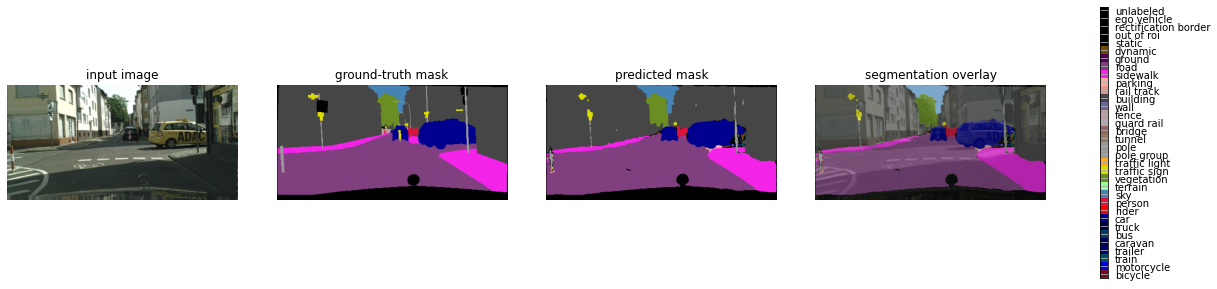

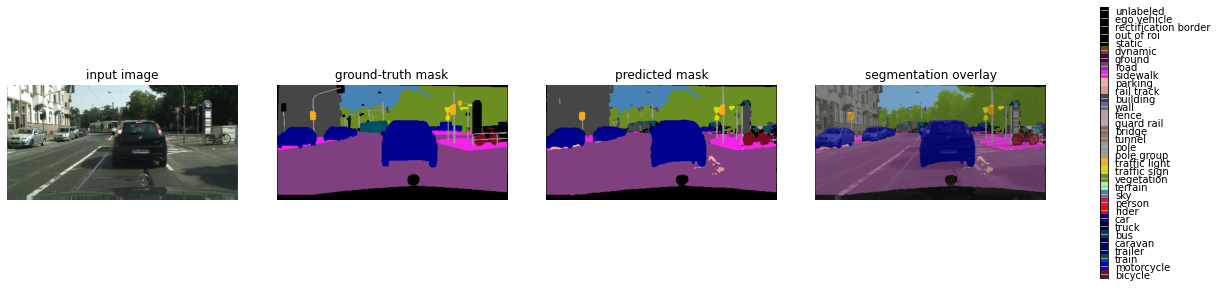

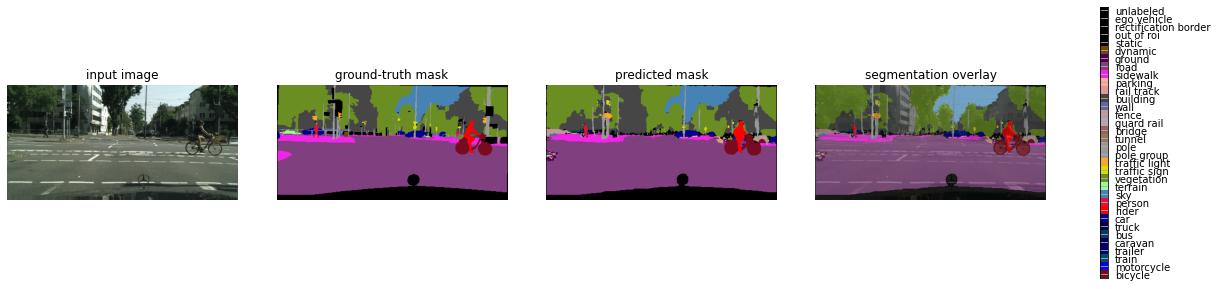

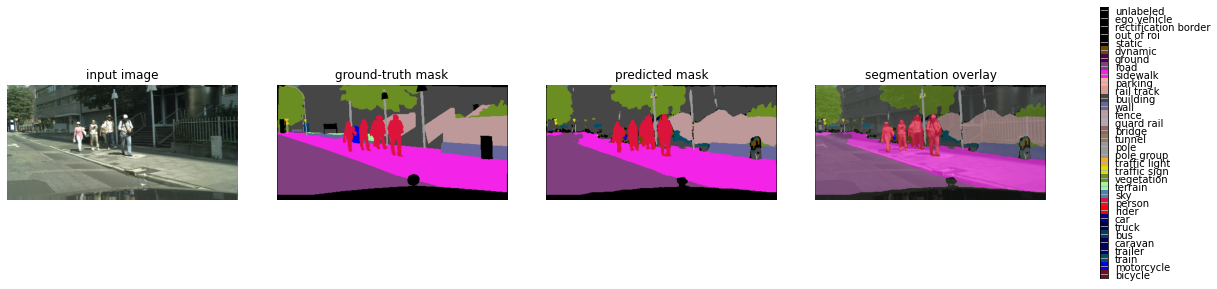

In [ ]:
# STEP 12: visualize the results
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [111, 74, 0],
        [81, 0, 81],
        [128, 64, 128],
        [244, 35, 232],
        [250, 170, 160],
        [230, 150, 140],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [180, 165, 180],
        [150, 100, 100],
        [150, 120, 90],
        [153, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 0, 90],
        [0, 0, 110],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]
    ], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, mask, pred_mask):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 5))
    grid_spec = gridspec.GridSpec(1, 5, width_ratios=[6, 6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    image = tf.keras.preprocessing.image.array_to_img(image)
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    gt_mask = label_to_color_image(mask).astype(np.uint8)
    plt.imshow(gt_mask)
    plt.axis('off')
    plt.title('ground-truth mask')

    plt.subplot(grid_spec[2])
    predicted_mask = label_to_color_image(pred_mask).astype(np.uint8)
    plt.imshow(predicted_mask)
    plt.axis('off')
    plt.title('predicted mask')

    plt.subplot(grid_spec[3])
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    ax = plt.subplot(grid_spec[4])
    plt.imshow(FULL_COLOR_MAP.astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(N_CLASSES), LABEL_NAMES)
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predicitons
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_HEIGHT, IMG_WIDTH, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        belonging to a certain class. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] segmentation mask with top 1 predictions
        for each pixel.
    """
    # pred_mask -> [IMG_HEIGHT, IMG_WIDTH, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax at encoded axis
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE,1 ]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask


def show_predictions(dataset, num):
    """Show num sample predictions.

    Parameters
    ----------
    dataset : [type]
        e.g. test_dataset
    num : int
        Number of sample to show
    """

    for image, mask in dataset.take(num):
        sample_image, sample_mask = image, mask
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3]
        # but sample_image[0] is [IMG_HEIGHT, IMG_WIDTH, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_HEIGHT, IMG_WIDTH, 3]
        # one_img_batch -> [1, IMG_HEIGHT, IMG_WIDTH, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # inference -> [1, IMG_HEIGHT, IMG_WIDTH, N_CLASS]
        inference = model.predict(one_img_batch)
        # pred_mask -> [1, IMG_HEIGHT, IMG_WIDTH, 1]
        pred_mask = create_mask(inference)
        # decode the one-hot ground-truth mask to get [1, IMG_HEIGHT, IMG_WIDTH, 1]
        mask = create_mask(sample_mask)
        # create slices of the image, mask and pred_mask -> [IMG_HEIGHT, IMG_WIDTH, 1/3]
        vis_segmentation(image[0], mask[0][:, :, 0], pred_mask[0][:, :, 0])


show_predictions(dataset=test_dataset, num=4)

In [ ]:
print('Now we can evaluate on the test set:')
model.evaluate(test_dataset)

def evaluate_dataset(dataset):
    """Evaluate a whole dataset with the MODEL loaded, for some specific labels.

    PARAMETERS:
    dataset: tf.data.dataset

    OUTPUT:
    Returns a table in the console specific class_iou values
    """
    acc_list = []
    intersection_list = []
    union_list = []
    print('evaluating the dataset...')
    for image, mask in dataset:
        sample_image, sample_mask = image, mask
        one_img_batch = sample_image[0][tf.newaxis, ...]
        inference = model.predict(one_img_batch)
        pred_mask = create_mask(inference)
        mask = create_mask(sample_mask)
        seg_map = np.array(pred_mask[0][:, :, 0]).astype(int)
        ground_truth = np.array(mask[0][:, :, 0]).astype(int)
        # merge some labels
        seg_map[np.logical_or(seg_map == 27, seg_map == 28)] = 26
        seg_map[np.logical_or(seg_map == 12, seg_map == 13)] = 11
        seg_map[seg_map == 25] = 24

        # calculate accuracy on valid area
        acc = (np.sum(seg_map[ground_truth != 3] == ground_truth[ground_truth != 3]) / np.sum(ground_truth !=3))
        acc_list.append(acc)
        # select valid labels for evaluation
        cm = confusion_matrix(ground_truth[ground_truth != 3], seg_map[ground_truth != 3],
                              labels=np.array([7, 8, 11, 17, 19, 20, 21, 22, 24, 26, 33]))

        intersection = (np.diag(cm))
        intersection_list.append(intersection)
        union = (np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm))
        union_list.append(union)
    class_iou = np.round(np.sum(intersection_list, 0) / np.sum(union_list, 0), 4)
    print('pixel accuracy: %.4f' % np.mean(acc_list))
    print('mean class IoU: %.4f' % np.mean(class_iou))
    print('class IoU:')
    print(tabulate([class_iou], headers=LABEL_NAMES[[7, 8, 11, 17, 19, 20, 21, 22, 24, 26, 33]]))


evaluate_dataset(dataset=test_dataset)

Now we can evaluate on the test set:
63/63 [==============================] - 38s 599ms/step - loss: 0.7023 - iou_score: 0.3708 - f1-score: 0.4293 - accuracy: 0.8965
evaluating the dataset...
pixel accuracy: 0.8870
mean class IoU: 0.7499
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car    bicycle
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------  ---------
0.9758      0.8155      0.9059  0.4825             0.44          0.6952        0.9124     0.5797    0.7282  0.9318     0.7815


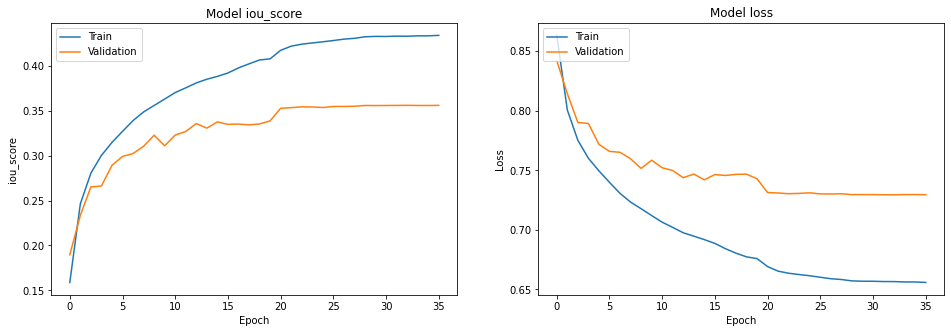

In [ ]:
# STEP 13: Plot training & validation iou_score values to visualize training process
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('demo.hdf5')